In [1]:
  import os
import glob
import random
import warnings
import numpy as np
import pandas as pd
import seaborn as sns
import tensorflow as tf
from keras.models import Model
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from keras.layers import Dense, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.applications import MobileNet,VGG16,VGG19, MobileNetV2, ResNet50, ResNet101,ResNet152
from keras.applications.inception_v3 import preprocess_input
from sklearn.metrics import classification_report, confusion_matrix

 


In [2]:
DATA_PATH = "/kaggle/input/preprocess-dataset-augmentation/AD_AUG"

In [3]:
def load_data(data_path):
    all_paths = glob.glob(f'{data_path}/**/*.*', recursive=True)
    labels = [os.path.split(os.path.split(path)[0])[1] for path in all_paths]
    return pd.DataFrame({'Filepath': all_paths, 'Target': labels}).sample(frac=1).reset_index(drop=True)

dataframe = load_data(DATA_PATH)

In [4]:
def explore_data(df):
    print("Dataset shape:", df.shape)
    plt.figure(figsize=(8, 5))
    sns.countplot(data=df, x='Target')
    plt.title("Distribution of Classes")
    plt.show()

Dataset shape: (12020, 2)


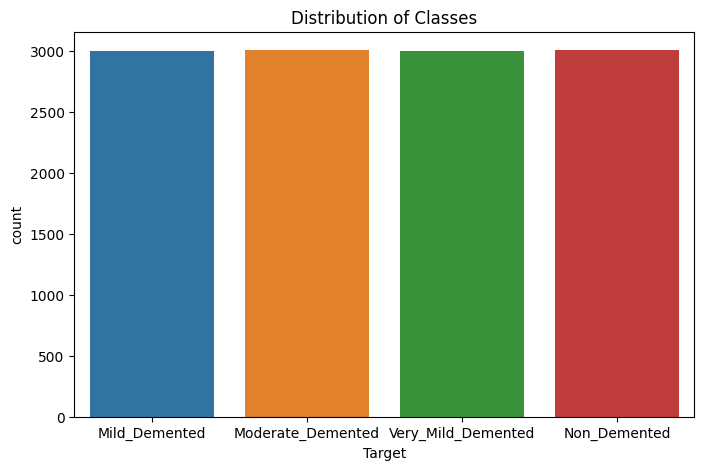

In [5]:
dataframe = load_data(DATA_PATH)
explore_data(dataframe)

In [6]:
import cv2
import numpy as np
from skimage.feature import local_binary_pattern
from tensorflow.keras.preprocessing.image import ImageDataGenerator

# Preprocessing: Grayscale,Denoising,CLAHE,Resize,Rescale
#Local Binary Pattern (LBP) for feature extraction

def preprocess_image(filepath):

    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)

    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)

    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)

    image = cv2.resize(image, (128, 128))

    image = image / 255.0

    lbp = local_binary_pattern(image, P=8, R=1, method="uniform")

    return lbp

In [9]:
def prepare_data(df):

    datagen = ImageDataGenerator(validation_split=0.2)

    def custom_image_loader(filepath):
        processed_image = preprocess_image(filepath)
        return np.expand_dims(processed_image, axis=-1)

    train_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='training',
        class_mode='categorical', shuffle=True,
        preprocessing_function=custom_image_loader
    )
    test_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='validation',
        class_mode='categorical', shuffle=False,
        preprocessing_function=custom_image_loader
    )

    return train_data, test_data


train_data, test_data = prepare_data(dataframe)

Found 9616 validated image filenames belonging to 4 classes.
Found 2404 validated image filenames belonging to 4 classes.


# **xgboost **

In [11]:
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Extract features using LBP
def extract_features(df):
    features = []
    labels = []
    for filepath, label in zip(df['Filepath'], df['Target']):
        lbp = preprocess_image(filepath)
        features.append(lbp.flatten())  # Flatten the LBP features to 1D
        labels.append(label)
    return np.array(features), np.array(labels)

# Step 2: Feature extraction
print("Extracting features...")
features, labels = extract_features(dataframe)

# Step 3: Encode labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Step 4: Train-test split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

# Step 5: Train the XGBoost model
xgb_model = xgb.XGBClassifier(
    n_estimators=100, learning_rate=0.1, max_depth=6, random_state=42, use_label_encoder=False, eval_metric='mlogloss'
)
xgb_model.fit(X_train, y_train)

# Step 6: Evaluate the model
y_pred = xgb_model.predict(X_test)
y_pred_proba = xgb_model.predict_proba(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

 

Extracting features...
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.85      0.89      0.87       600
 Moderate_Demented       0.93      0.91      0.92       602
      Non_Demented       0.99      1.00      0.99       602
Very_Mild_Demented       0.91      0.86      0.88       600

          accuracy                           0.92      2404
         macro avg       0.92      0.92      0.92      2404
      weighted avg       0.92      0.92      0.92      2404

Accuracy: 0.9168


# **KNN**

In [12]:
def prepare_data(df):

    datagen = ImageDataGenerator(validation_split=0.2)

    def custom_image_loader(filepath):
        processed_image = preprocess_image(filepath)
        return np.expand_dims(processed_image, axis=-1)

    train_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='training',
        class_mode='categorical', shuffle=True,
        preprocessing_function=custom_image_loader
    )
    test_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='validation',
        class_mode='categorical', shuffle=False,
        preprocessing_function=custom_image_loader
    )

    return train_data, test_data


train_data, test_data = prepare_data(dataframe)

Found 9616 validated image filenames belonging to 4 classes.
Found 2404 validated image filenames belonging to 4 classes.


Extracting features...
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.89      0.51      0.65       600
 Moderate_Demented       0.85      0.95      0.89       602
      Non_Demented       0.98      0.95      0.96       602
Very_Mild_Demented       0.65      0.86      0.74       600

          accuracy                           0.82      2404
         macro avg       0.84      0.82      0.81      2404
      weighted avg       0.84      0.82      0.81      2404

Accuracy: 0.8178


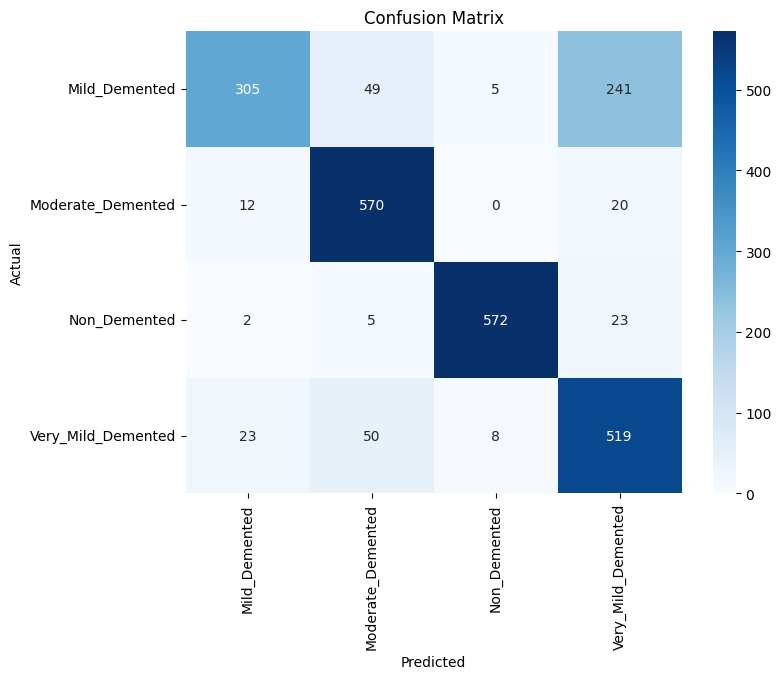

ROC AUC Score: 0.9549


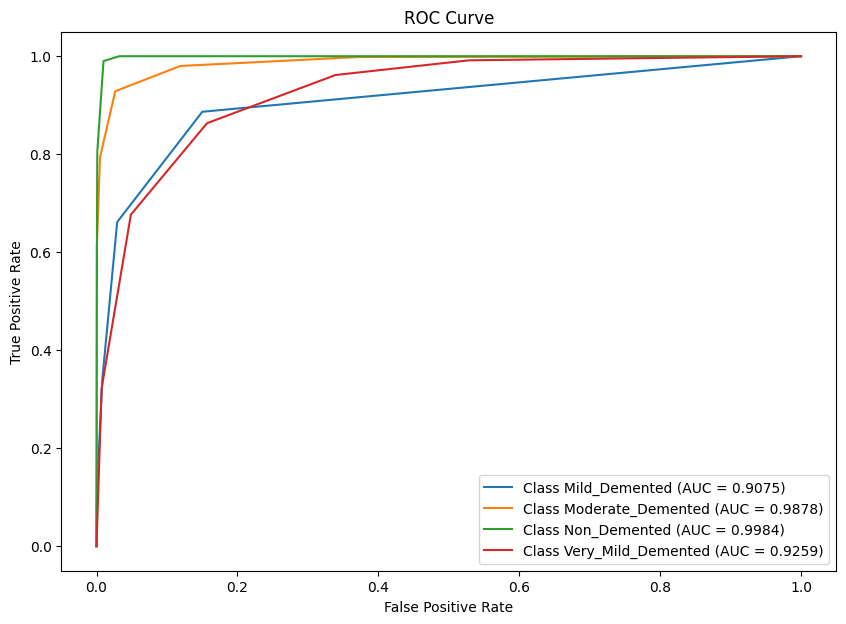

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.metrics import roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Feature Extraction
def extract_features_knn(df):
    features = []
    labels = []
    for filepath, label in zip(df['Filepath'], df['Target']):
        lbp = preprocess_image(filepath)
        features.append(lbp.flatten())  # Flatten the LBP features for KNN
        labels.append(label)
    return np.array(features), np.array(labels)

print("Extracting features...")
features, labels = extract_features_knn(dataframe)

# Step 2: Encode Labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

# Step 4: Standardize the Features
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Step 5: Train the KNN Model
knn_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_model.fit(X_train, y_train)

# Step 6: Predict and Evaluate
y_pred = knn_model.predict(X_test)
y_pred_proba = knn_model.predict_proba(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")

# Step 7: Plot Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 8: Plot ROC Curve
plt.figure(figsize=(10, 7))
roc_auc = roc_auc_score(y_test, y_pred_proba, multi_class='ovr')
print(f"ROC AUC Score: {roc_auc:.4f}")
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_proba[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc_score((y_test == i).astype(int), y_pred_proba[:, i]):.4f})")

plt.title("ROC Curve")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# **XGBOOST +KNN**

In [14]:
def prepare_data(df):

    datagen = ImageDataGenerator(validation_split=0.2)

    def custom_image_loader(filepath):
        processed_image = preprocess_image(filepath)
        return np.expand_dims(processed_image, axis=-1)

    train_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='training',
        class_mode='categorical', shuffle=True,
        preprocessing_function=custom_image_loader
    )
    test_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='validation',
        class_mode='categorical', shuffle=False,
        preprocessing_function=custom_image_loader
    )

    return train_data, test_data


train_data, test_data = prepare_data(dataframe)

Found 9616 validated image filenames belonging to 4 classes.
Found 2404 validated image filenames belonging to 4 classes.


Extracting features...
Classification Report for Ensemble Model:
                    precision    recall  f1-score   support

     Mild_Demented       0.92      0.81      0.86       600
 Moderate_Demented       0.97      0.97      0.97       602
      Non_Demented       0.99      1.00      0.99       602
Very_Mild_Demented       0.85      0.93      0.89       600

          accuracy                           0.93      2404
         macro avg       0.93      0.93      0.93      2404
      weighted avg       0.93      0.93      0.93      2404

Ensemble Accuracy: 0.9276


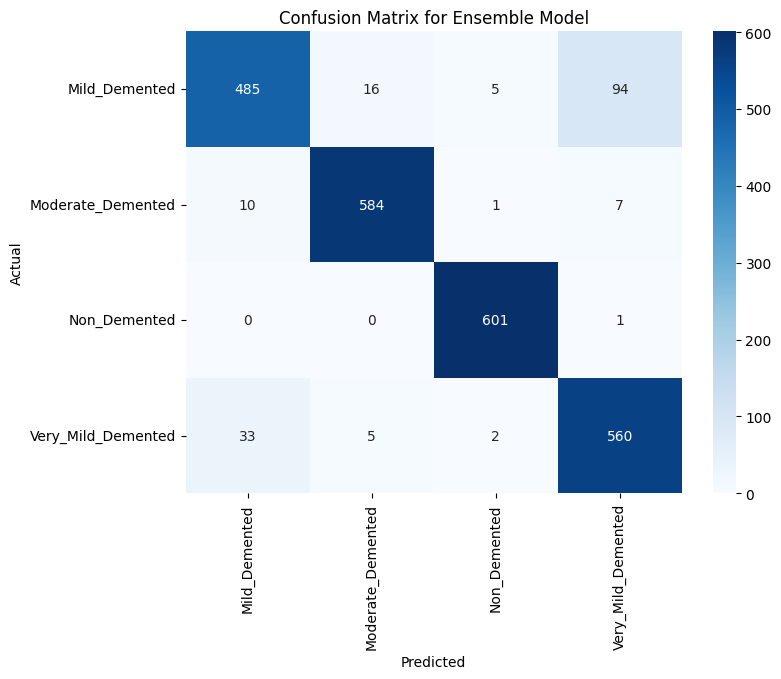

ROC AUC Score for Ensemble Model: 0.9916


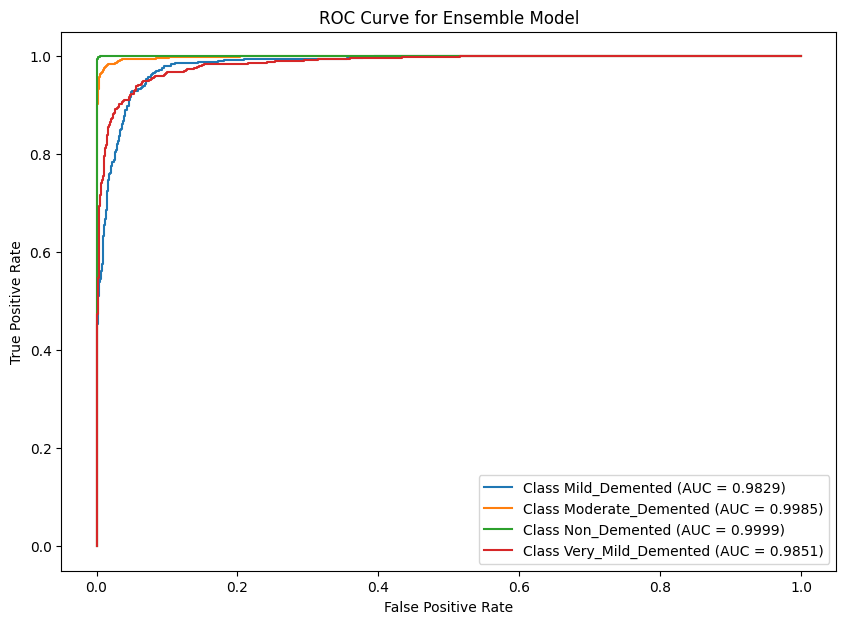

In [15]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt
import numpy as np

# Step 1: Feature Extraction
def extract_features_ensemble(df):
    features = []
    labels = []
    for filepath, label in zip(df['Filepath'], df['Target']):
        lbp = preprocess_image(filepath)
        features.append(lbp.flatten())  # Flatten the LBP features for both models
        labels.append(label)
    return np.array(features), np.array(labels)

print("Extracting features...")
features, labels = extract_features_ensemble(dataframe)

# Step 2: Encode Labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

# Step 4: Standardize Features for KNN
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train XGBoost Model
xgb_model = XGBClassifier(use_label_encoder=False, eval_metric='logloss', n_estimators=100, max_depth=6, learning_rate=0.1)
xgb_model.fit(X_train, y_train)

# Step 6: Train KNN Model
knn_model = KNeighborsClassifier(n_neighbors=5, metric='euclidean')
knn_model.fit(X_train_scaled, y_train)

# Step 7: Ensemble Predictions
xgb_probs = xgb_model.predict_proba(X_test)
knn_probs = knn_model.predict_proba(X_test_scaled)

# Weighted Averaging for Ensemble
ensemble_probs = 0.6 * xgb_probs + 0.4 * knn_probs
ensemble_preds = np.argmax(ensemble_probs, axis=1)

# Step 8: Evaluate the Ensemble Model
print("Classification Report for Ensemble Model:")
print(classification_report(y_test, ensemble_preds, target_names=label_encoder.classes_))
print(f"Ensemble Accuracy: {accuracy_score(y_test, ensemble_preds):.4f}")

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, ensemble_preds)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for Ensemble Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 9: Plot ROC Curve for Ensemble Model
plt.figure(figsize=(10, 7))
roc_auc = roc_auc_score(y_test, ensemble_probs, multi_class='ovr')
print(f"ROC AUC Score for Ensemble Model: {roc_auc:.4f}")
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), ensemble_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc_score((y_test == i).astype(int), ensemble_probs[:, i]):.4f})")

plt.title("ROC Curve for Ensemble Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


# **SVM **

In [16]:
def prepare_data(df):

    datagen = ImageDataGenerator(validation_split=0.2)

    def custom_image_loader(filepath):
        processed_image = preprocess_image(filepath)
        return np.expand_dims(processed_image, axis=-1)

    train_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='training',
        class_mode='categorical', shuffle=True,
        preprocessing_function=custom_image_loader
    )
    test_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='validation',
        class_mode='categorical', shuffle=False,
        preprocessing_function=custom_image_loader
    )

    return train_data, test_data


train_data, test_data = prepare_data(dataframe)

Found 9616 validated image filenames belonging to 4 classes.
Found 2404 validated image filenames belonging to 4 classes.


Extracting features...
Classification Report for SVM Model:
                    precision    recall  f1-score   support

     Mild_Demented       0.80      0.81      0.81       600
 Moderate_Demented       0.82      0.84      0.83       602
      Non_Demented       1.00      1.00      1.00       602
Very_Mild_Demented       0.85      0.81      0.83       600

          accuracy                           0.86      2404
         macro avg       0.86      0.86      0.86      2404
      weighted avg       0.86      0.86      0.86      2404



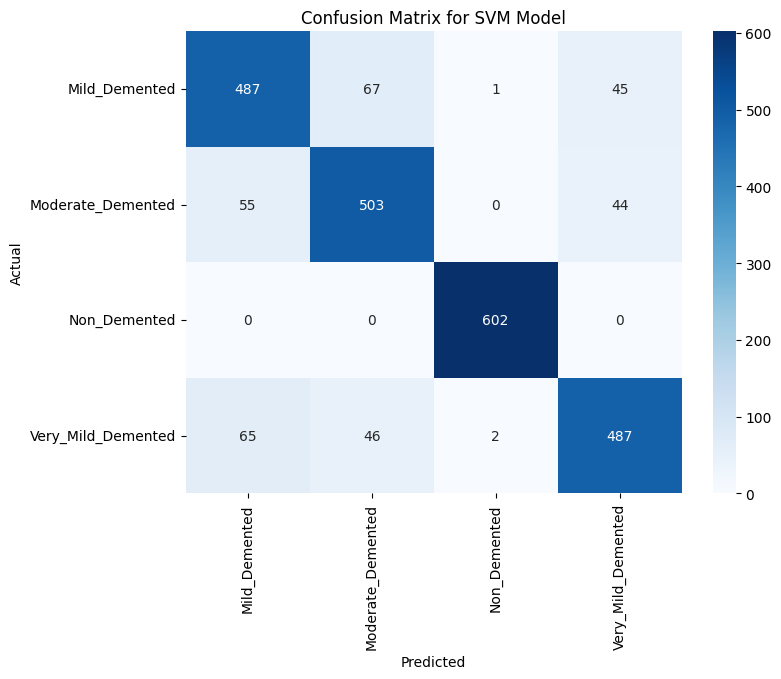

ROC AUC Score for SVM Model: 0.9730


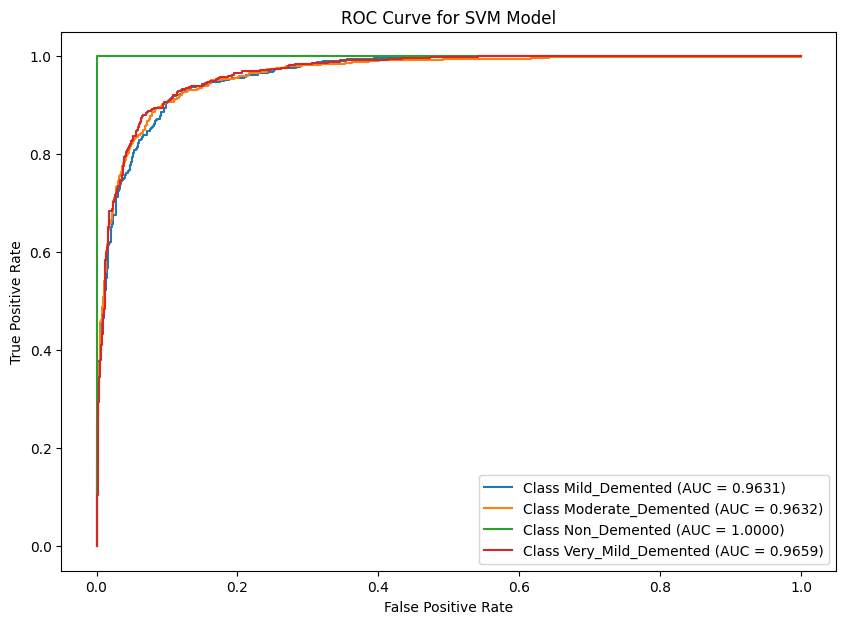

In [17]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.svm import SVC
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, roc_curve, roc_auc_score
import matplotlib.pyplot as plt
import seaborn as sns

# Step 1: Feature Extraction
def extract_features_svm(df):
    features = []
    labels = []
    for filepath, label in zip(df['Filepath'], df['Target']):
        lbp = preprocess_image(filepath)
        features.append(lbp.flatten())  # Flatten the LBP features
        labels.append(label)
    return np.array(features), np.array(labels)

print("Extracting features...")
features, labels = extract_features_svm(dataframe)

# Step 2: Encode Labels
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)

# Step 3: Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(
    features, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

# Step 4: Standardize Features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Step 5: Train SVM Model
svm_model = SVC(kernel='linear', probability=True, random_state=42)
svm_model.fit(X_train_scaled, y_train)

# Step 6: Evaluate SVM Model
y_pred = svm_model.predict(X_test_scaled)
y_pred_probs = svm_model.predict_proba(X_test_scaled)

# Classification Report
print("Classification Report for SVM Model:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Confusion Matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix for SVM Model")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Step 7: Plot ROC Curve
plt.figure(figsize=(10, 7))
roc_auc = roc_auc_score(y_test, y_pred_probs, multi_class='ovr')
print(f"ROC AUC Score for SVM Model: {roc_auc:.4f}")
for i, class_name in enumerate(label_encoder.classes_):
    fpr, tpr, _ = roc_curve((y_test == i).astype(int), y_pred_probs[:, i])
    plt.plot(fpr, tpr, label=f"Class {class_name} (AUC = {roc_auc_score((y_test == i).astype(int), y_pred_probs[:, i]):.4f})")

plt.title("ROC Curve for SVM Model")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.show()


In [7]:
def prepare_data(df):

    datagen = ImageDataGenerator(validation_split=0.2)

    def custom_image_loader(filepath):
        processed_image = preprocess_image(filepath)
        return np.expand_dims(processed_image, axis=-1)

    train_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='training',
        class_mode='categorical', shuffle=True,
        preprocessing_function=custom_image_loader
    )
    test_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='validation',
        class_mode='categorical', shuffle=False,
        preprocessing_function=custom_image_loader
    )

    return train_data, test_data


train_data, test_data = prepare_data(dataframe)

Found 9616 validated image filenames belonging to 4 classes.
Found 2404 validated image filenames belonging to 4 classes.


# **LogisticRegression**

Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.80      0.82      0.81       600
 Moderate_Demented       0.82      0.82      0.82       602
      Non_Demented       0.99      1.00      0.99       602
Very_Mild_Demented       0.82      0.78      0.80       600

          accuracy                           0.85      2404
         macro avg       0.85      0.85      0.85      2404
      weighted avg       0.85      0.85      0.85      2404



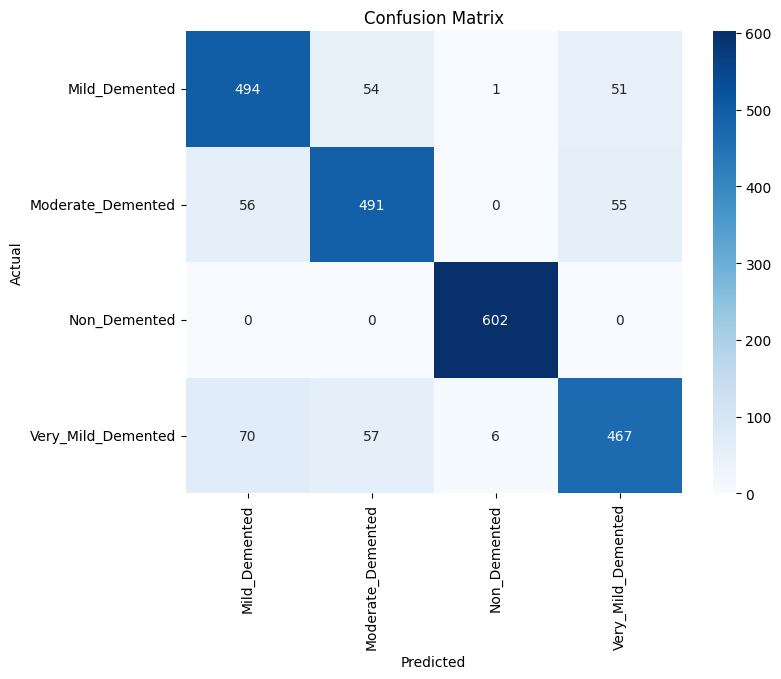

In [8]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Function to preprocess all images and extract LBP features
def extract_features_and_labels(df):
    features = []
    labels = []

    for _, row in df.iterrows():
        filepath = row['Filepath']
        label = row['Target']

        # Preprocess the image and extract LBP features
        lbp_features = preprocess_image(filepath).flatten()
        features.append(lbp_features)
        labels.append(label)

    return np.array(features), np.array(labels)

# Extract features and labels from the dataframe
X, y = extract_features_and_labels(dataframe)

# Encode class labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Train a logistic regression model
logreg = LogisticRegression(max_iter=1000, random_state=42)
logreg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = logreg.predict(X_test)

# Generate classification report
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [9]:
from sklearn.metrics import accuracy_score

# Calculate and display test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")


Test Accuracy: 0.85


# **Decision Tree**

In [11]:
def prepare_data(df):

    datagen = ImageDataGenerator(validation_split=0.2)

    def custom_image_loader(filepath):
        processed_image = preprocess_image(filepath)
        return np.expand_dims(processed_image, axis=-1)

    train_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='training',
        class_mode='categorical', shuffle=True,
        preprocessing_function=custom_image_loader
    )
    test_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='validation',
        class_mode='categorical', shuffle=False,
        preprocessing_function=custom_image_loader
    )

    return train_data, test_data


train_data, test_data = prepare_data(dataframe)

Found 9616 validated image filenames belonging to 4 classes.
Found 2404 validated image filenames belonging to 4 classes.


Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.43      0.45      0.44       600
 Moderate_Demented       0.48      0.48      0.48       602
      Non_Demented       0.94      0.96      0.95       602
Very_Mild_Demented       0.49      0.47      0.48       600

          accuracy                           0.59      2404
         macro avg       0.59      0.59      0.59      2404
      weighted avg       0.59      0.59      0.59      2404

Test Accuracy: 0.59


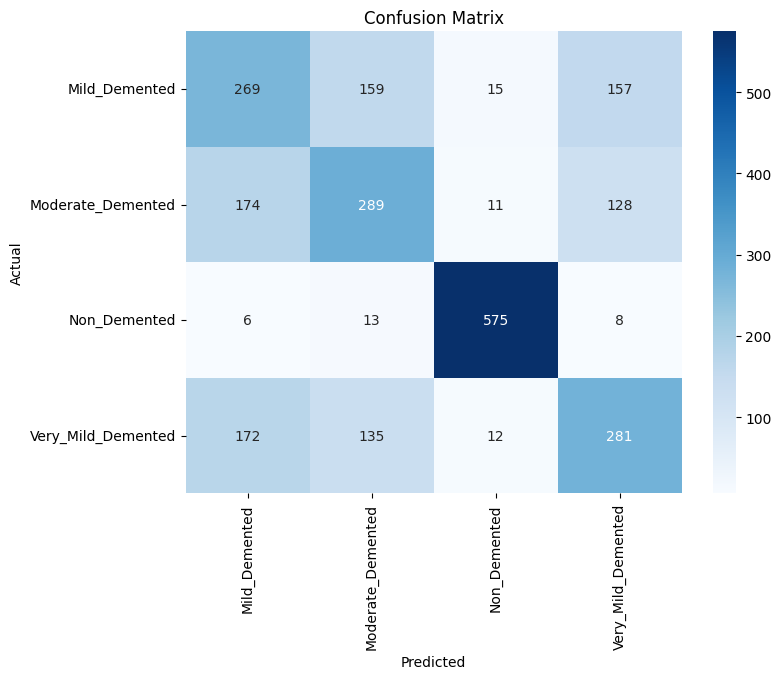

In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split

# Function to preprocess all images and extract LBP features
def extract_features_and_labels(df):
    features = []
    labels = []

    for _, row in df.iterrows():
        filepath = row['Filepath']
        label = row['Target']

        # Preprocess the image and extract LBP features
        lbp_features = preprocess_image(filepath).flatten()
        features.append(lbp_features)
        labels.append(label)

    return np.array(features), np.array(labels)

# Extract features and labels from the dataframe
X, y = extract_features_and_labels(dataframe)

# Encode class labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Train a Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)
dt_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = dt_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


# **naive_bayes**

In [13]:
def prepare_data(df):

    datagen = ImageDataGenerator(validation_split=0.2)

    def custom_image_loader(filepath):
        processed_image = preprocess_image(filepath)
        return np.expand_dims(processed_image, axis=-1)

    train_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='training',
        class_mode='categorical', shuffle=True,
        preprocessing_function=custom_image_loader
    )
    test_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='validation',
        class_mode='categorical', shuffle=False,
        preprocessing_function=custom_image_loader
    )

    return train_data, test_data


train_data, test_data = prepare_data(dataframe)

Found 9616 validated image filenames belonging to 4 classes.
Found 2404 validated image filenames belonging to 4 classes.


Cross-validation Accuracy: 0.49 ± 0.02
Classification Report:
                    precision    recall  f1-score   support

     Mild_Demented       0.34      0.83      0.48       600
 Moderate_Demented       0.36      0.04      0.08       602
      Non_Demented       0.72      1.00      0.84       602
Very_Mild_Demented       0.53      0.03      0.06       600

          accuracy                           0.48      2404
         macro avg       0.49      0.48      0.37      2404
      weighted avg       0.49      0.48      0.37      2404

Test Accuracy: 0.48


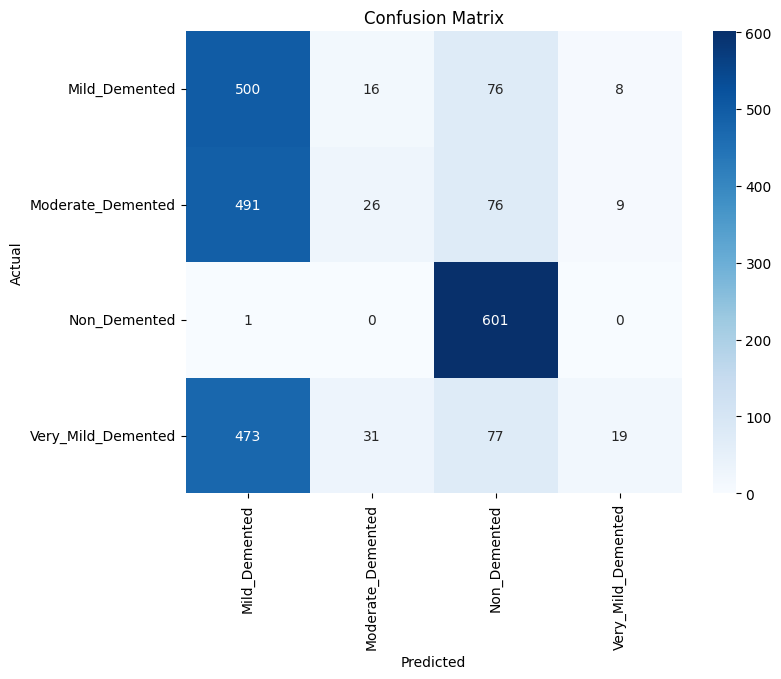

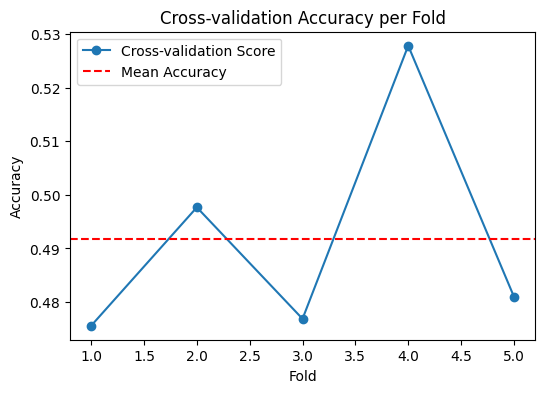

In [14]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns

# Function to preprocess all images and extract LBP features
def extract_features_and_labels(df):
    features = []
    labels = []

    for _, row in df.iterrows():
        filepath = row['Filepath']
        label = row['Target']

        # Preprocess the image and extract LBP features
        lbp_features = preprocess_image(filepath).flatten()
        features.append(lbp_features)
        labels.append(label)

    return np.array(features), np.array(labels)

# Extract features and labels from the dataframe
X, y = extract_features_and_labels(dataframe)

# Encode class labels to integers
label_encoder = LabelEncoder()
y_encoded = label_encoder.fit_transform(y)

# Split data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y_encoded, test_size=0.2, random_state=42, stratify=y_encoded)

# Train a Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(X_train, y_train)

# Perform cross-validation to check model stability
cv_scores = cross_val_score(nb_model, X_train, y_train, cv=5)
print(f"Cross-validation Accuracy: {np.mean(cv_scores):.2f} ± {np.std(cv_scores):.2f}")

# Make predictions on the test set
y_pred = nb_model.predict(X_test)

# Evaluate the model
print("Classification Report:")
print(classification_report(y_test, y_pred, target_names=label_encoder.classes_))

# Calculate test accuracy
test_accuracy = accuracy_score(y_test, y_pred)
print(f"Test Accuracy: {test_accuracy:.2f}")

# Plot confusion matrix
conf_matrix = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# Plot best fitting (e.g., accuracy across splits)
plt.figure(figsize=(6, 4))
plt.plot(range(1, len(cv_scores) + 1), cv_scores, marker='o', label='Cross-validation Score')
plt.axhline(y=np.mean(cv_scores), color='r', linestyle='--', label='Mean Accuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.title('Cross-validation Accuracy per Fold')
plt.legend()
plt.show()


# **RandomForestClassifier**

In [15]:
def prepare_data(df):

    datagen = ImageDataGenerator(validation_split=0.2)

    def custom_image_loader(filepath):
        processed_image = preprocess_image(filepath)
        return np.expand_dims(processed_image, axis=-1)

    train_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='training',
        class_mode='categorical', shuffle=True,
        preprocessing_function=custom_image_loader
    )
    test_data = datagen.flow_from_dataframe(
        df, x_col='Filepath', y_col='Target', target_size=(128, 128), batch_size=16, subset='validation',
        class_mode='categorical', shuffle=False,
        preprocessing_function=custom_image_loader
    )

    return train_data, test_data


train_data, test_data = prepare_data(dataframe)

Found 9616 validated image filenames belonging to 4 classes.
Found 2404 validated image filenames belonging to 4 classes.


100%|██████████| 12020/12020 [05:25<00:00, 36.91it/s]


Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best Parameters: {'max_depth': 30, 'max_features': 'sqrt', 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 300}
Classification Report:

                    precision    recall  f1-score   support

     Mild_Demented       0.59      0.61      0.60       600
 Moderate_Demented       0.58      0.58      0.58       602
      Non_Demented       0.95      0.95      0.95       602
Very_Mild_Demented       0.63      0.60      0.62       600

          accuracy                           0.69      2404
         macro avg       0.69      0.69      0.69      2404
      weighted avg       0.69      0.69      0.69      2404

Confusion Matrix:



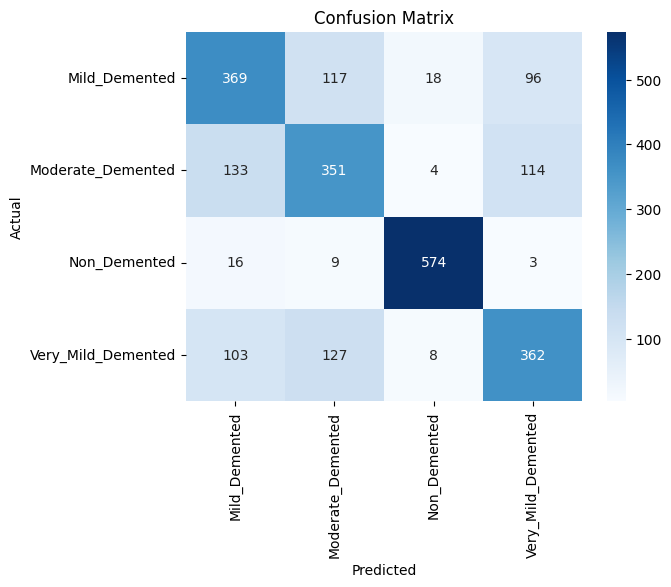

In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from tqdm import tqdm
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Modify preprocess_image to include adjustable LBP parameters
def preprocess_image(filepath, P=8, R=1, method="uniform"):
    image = cv2.imread(filepath, cv2.IMREAD_GRAYSCALE)
    image = cv2.fastNlMeansDenoising(image, None, 10, 7, 21)
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    image = clahe.apply(image)
    image = cv2.resize(image, (128, 128))
    image = image / 255.0
    lbp = local_binary_pattern(image, P=P, R=R, method=method)  # Adjustable LBP parameters
    return lbp

# 2. Feature extraction with histograms
def extract_features_labels(dataframe, P=8, R=1, method="uniform"):
    features, labels = [], []
    for _, row in tqdm(dataframe.iterrows(), total=len(dataframe)):
        lbp = preprocess_image(row['Filepath'], P, R, method)
        hist, _ = np.histogram(lbp.ravel(), bins=np.arange(0, lbp.max() + 2), density=True)
        features.append(hist)
        labels.append(row['Target'])
    return np.array(features), np.array(labels)

# Extract features and encode labels
P, R, method = 8, 1, "uniform"  # Initial LBP parameters (tunable)
X, y = extract_features_labels(dataframe, P, R, method)
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y)

# Train-test split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# 3. Random Forest with Hyperparameter Tuning
param_grid = {
    'n_estimators': [100, 200, 300],            # Number of trees
    'max_depth': [None, 10, 20, 30],           # Maximum depth of trees
    'min_samples_split': [2, 5, 10],           # Minimum samples required to split a node
    'min_samples_leaf': [1, 2, 4],             # Minimum samples in a leaf node
    'max_features': ['sqrt', 'log2', None]     # Number of features to consider for best split
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=3, n_jobs=-1, verbose=1, scoring='accuracy')
grid_search.fit(X_train, y_train)

# Best model and evaluation
best_rf = grid_search.best_estimator_
print("Best Parameters:", grid_search.best_params_)

y_pred = best_rf.predict(X_val)
print("Classification Report:\n")
print(classification_report(y_val, y_pred, target_names=label_encoder.classes_))

print("Confusion Matrix:\n")
cm = confusion_matrix(y_val, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix')
plt.show()
